In [6]:
import numpy as np
import pylab as pl
import scipy as sp
import matplotlib.pyplot as pl
import os as os
import sklearn
import sklearn.cluster as sk
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR
import warnings 
warnings.filterwarnings("ignore")

seed=123

# Data visualization and pre-processing

In [7]:
ECoG=np.load("sample_data/ECoG.npz")

In [8]:
Xall,Yall,Fe=ECoG["Xall"],ECoG["Yall"],ECoG["Fe"] 

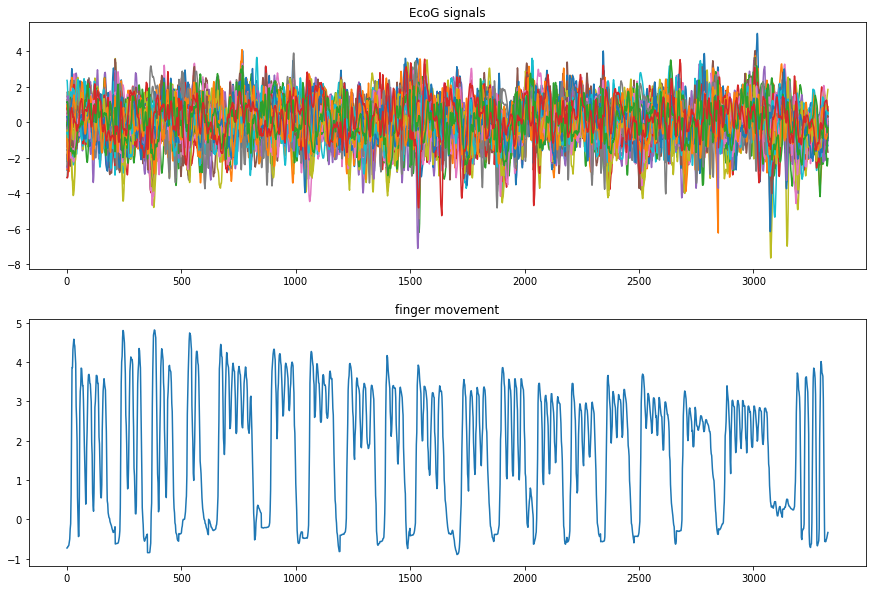

In [9]:
fig,axes=pl.subplots(2,1,figsize=(15,10))
axes[0].plot(Xall)
axes[0].set_title("EcoG signals")
axes[1].plot(Yall)
axes[1].set_title("finger movement")
pl.show()

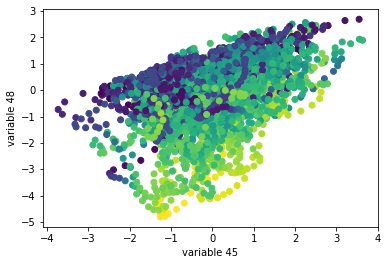

In [10]:
pl.scatter(Xall[:,45],Xall[:,48],c=Yall)
pl.xlabel("variable 45")
pl.ylabel("variable 48")
pl.show()

We see a degradation of color from yellow to blue reflecting the how values of the dataset are distributed among the variables $48$ and $45$.

In [57]:
n=1000                                                                          # train dataset length
m=len(Xall)-n                                                                   # test dataset length
x_train,x_test=Xall[:n,:],Xall[n:,:]
y_train,y_test=Yall[:n,:],Yall[n:,:]

# Least Squares regression (LS)

In [12]:
X=np.concatenate((x_train,np.ones(shape=(x_train.shape[0],1))),1)

In [13]:
theta=np.linalg.solve(X.T.dot(X),X.T.dot(y_train))
w,b=theta[:-1],theta[-1]

In [14]:
y_hat_train=x_train.dot(w)+b
y_hat_test=x_test.dot(w)+b

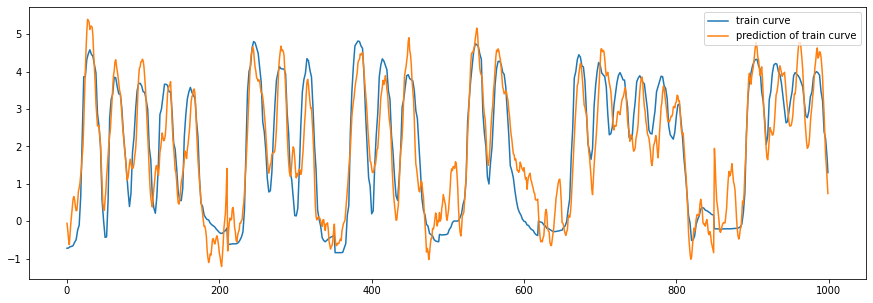

In [15]:
pl.figure(figsize=(15,5))
pl.plot(y_train,label="train curve")
pl.plot(y_hat_train,label="prediction of train curve")
pl.legend()
pl.show()

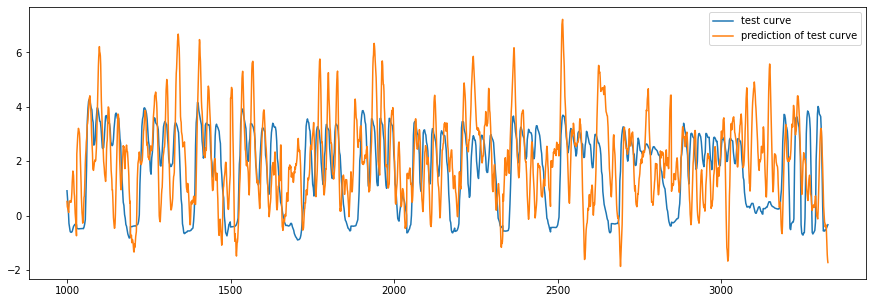

In [16]:
pl.figure(figsize=(15,5))
pl.plot(range(n,len(Yall)),y_test,label="test curve")
pl.plot(range(n,len(Yall)),y_hat_test,label="prediction of test curve")
pl.legend()
pl.show()

On the train dataset, the prediction curve fits the train curve as expected. However, if we take a look on the performance on the test dataset, we see that at the beginnig the prediction curve approximates the test curve. But as long as we follow their correspondance along time we see that prediction curve predicts badly the test one. This reflects bad linearity relationship between the predicted values and the ground truth.

We can understand this by the fact that brain behavior (giving the order to the finger to move in which direction) is not easily predictable by electrods for a long period of time for a given measurement.

In [17]:
print(f'MSE on train: {mean_squared_error(y_train,y_hat_train)}')
print(f'MSE on test: {mean_squared_error(y_test,y_hat_test)}')

print(f'R² on train: {metrics.r2_score(y_train,y_hat_train)}')
print(f'R² on test: {metrics.r2_score(y_test,y_hat_test)}')

MSE on train: 0.5040654614476062
MSE on test: 3.045536876760174
R² on train: 0.8395001217500111
R² on test: -0.428170063022258


On train dataset, we have a low value of $MSE$ error of $0.5$ and a $0.83$ value of $R^2$ reflecting a good fit to the train dataset. However, on the test dataset we had a value of $3$ for the $MSE$ error and $-0.42$ for $R^2$ reflecting bad prediction on test dataset and absence of correlation between predicted values and the true value of test dataset. 

We conclude that we have a problem of **overfitting** on the train set since which is expected since we work in high dimension. A good solution mmay be to use regularization (Lasso and Ridge) and retrain the model.

In [18]:
LS=LinearRegression()
LS.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
print(sum((w.flatten()-LS.coef_.flatten())**2))                              #Squared error between weights
print(((b-LS.intercept_)**2)[0])                                             #Squared error between intercepts

1.6083903867729997e-27
1.597443333072549e-29


We note that we retrieve the same values of weights and intercept as the linear regression model we created at first.

# Ridge regression

In [20]:
Ridge_reg = Ridge(alpha=1)
Ridge_reg.fit(x_train,y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [21]:
y_train_hat=Ridge_reg.predict(x_train)
y_test_hat=Ridge_reg.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.5041768297327897
MSE on test: 3.003842959535568
R² on train: 0.8394646608871272
R² on test: -0.40861817223916064


With a value of $\lambda=1$, we get approximately the same values of $MSE$ and $R^2$ as a simple linear regression. This value of $\lambda$ does not resolve the problem of overfitting. We should look for higher values penalising weights.

In [22]:
lmbd=np.logspace(-3,5,num=100)                                                  #range value of lambda
W=np.zeros((100,64))
y_hat_train=np.zeros((100,n))
y_hat_test=np.zeros((100,m))
MSE_train=np.zeros(100)
MSE_test=np.zeros(100)
for i in range(len(lmbd)):
    mod=Ridge(alpha=lmbd[i])
    mod.fit(x_train,y_train)

    y_hat_test[i,:]=np.ravel(mod.predict(x_test))
    y_hat_train[i,:]=np.ravel(mod.predict(x_train))
    W[i,:]=np.ravel(mod.coef_)

    MSE_train[i]=mean_squared_error(y_hat_train[i,:],y_train)
    MSE_test[i]=mean_squared_error(y_hat_test[i,:],y_test)

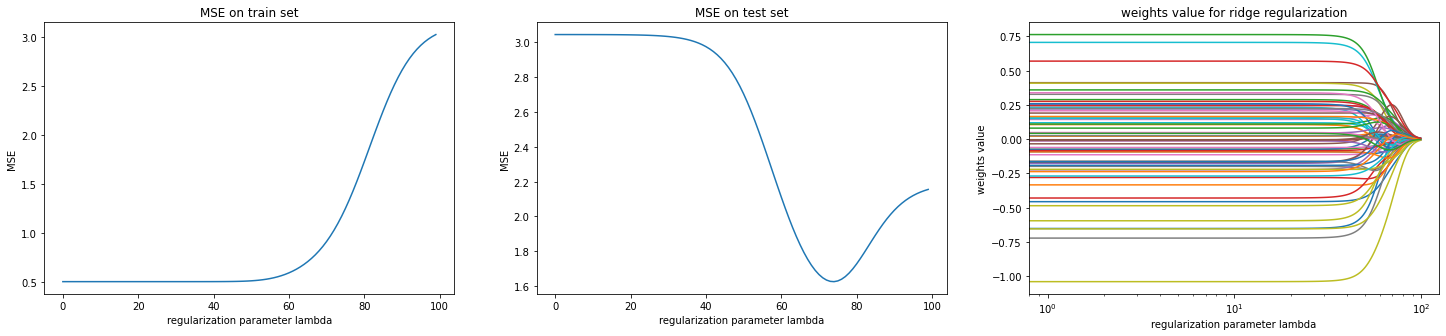

In [23]:
fig,axes=pl.subplots(1,3,figsize=(25,5))

axes[0].plot(MSE_train)
axes[0].set_xlabel("regularization parameter lambda")
axes[0].set_ylabel("MSE")
axes[0].set_title("MSE on train set")

axes[1].plot(MSE_test)
axes[1].set_xlabel("regularization parameter lambda")
axes[1].set_ylabel("MSE")
axes[1].set_title("MSE on test set")

axes[2].plot(W)
axes[2].set_xscale('log')
axes[2].set_xlabel("regularization parameter lambda")
axes[2].set_ylabel("weights value")
axes[2].set_title("weights value for ridge regularization")
pl.show()

In [24]:
index=np.argmin(MSE_test)
lmbd_opt=lmbd[index]
print("valeur optimale de lambda: {}".format(lmbd_opt)) 
print("MSE error on Test: {}".format(MSE_test[np.argmin(MSE_test)])) 
Ridge_opt=Ridge(alpha=lmbd_opt)
Ridge_opt.fit(x_train,y_train)

valeur optimale de lambda: 954.5484566618347
MSE error on Test: 1.6239059826952074


Ridge(alpha=954.5484566618347, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

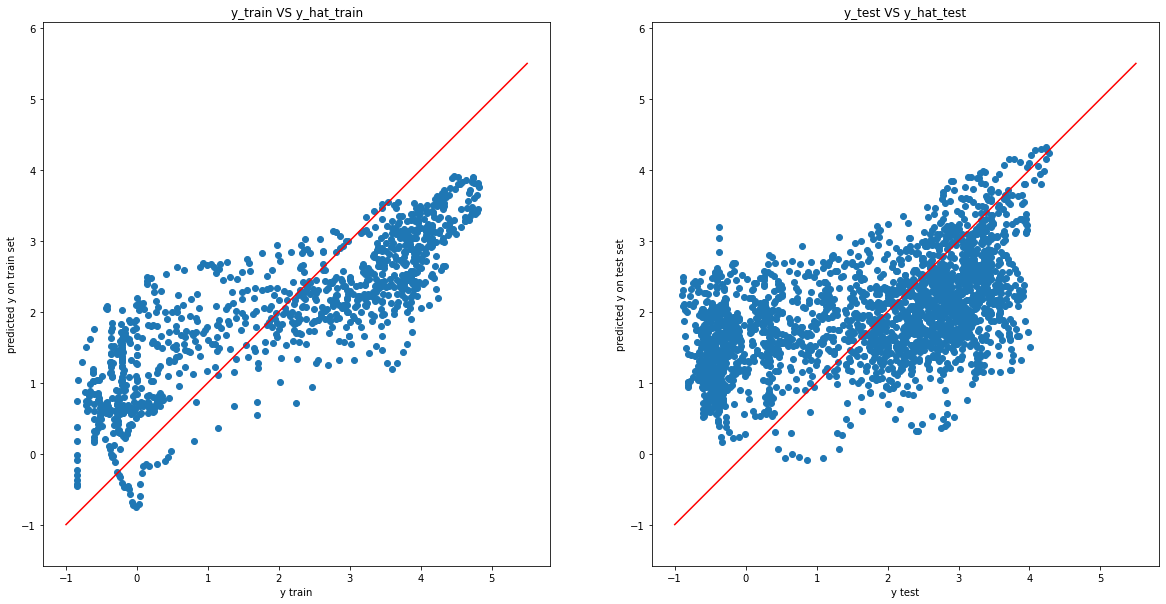

In [25]:
y_hat_test=Ridge_opt.predict(x_test)
y_hat_train=Ridge_opt.predict(x_train)

fig,axes=pl.subplots(1,2,figsize=(20,10))
line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[0])

axes[0].scatter(y_train,y_hat_train)
axes[0].add_line(line)
axes[0].set_xlabel("y train")
axes[0].set_ylabel("predicted y on train set")
axes[0].set_title("y_train VS y_hat_train")
axes[0].axis('equal')

line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[1])

#axes[1].add_line(line)
axes[1].scatter(y_test,y_hat_test)
axes[1].add_line(line)
axes[1].set_xlabel("y test")
axes[1].set_ylabel("predicted y on test set")
axes[1].set_title("y_test VS y_hat_test")
axes[1].axis('equal')

pl.show()

We don't see a good alignment of the predictions with the ground truth for both train and test dataset although the dispersion is less wide on train dataset. For this reason, the ridge regressor didn't enhance very well the LS regressor.

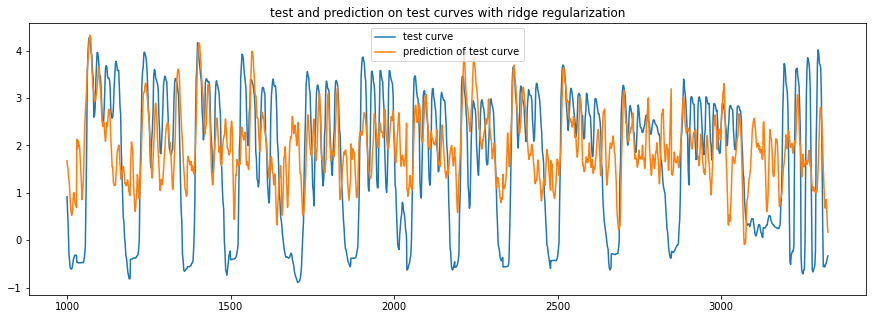

In [26]:
pl.figure(figsize=(15,5))
pl.plot(range(n,n+m),y_test,label="test curve")
pl.plot(range(n,n+m),y_hat_test,label="prediction of test curve")
pl.title("test and prediction on test curves with ridge regularization")
pl.legend()
pl.show()

On the test dataset, we see that the predicted curve captures the variations of the test curve. However, it doesn't reach the low values of the test curve and at the end we see that the prediction is not accurate. But in general the obtained curve is better than the one of LS. In fact we don't get no more the very large values that we saw in the prediction curve over test dataset with the LS model.

In [27]:
print(f'MSE on train: {mean_squared_error(y_train,y_hat_train)}')
print(f'MSE on test: {mean_squared_error(y_test,y_hat_test)}')

print(f'R² on train: {metrics.r2_score(y_train,y_hat_train)}')
print(f'R² on test: {metrics.r2_score(y_test,y_hat_test)}')

MSE on train: 1.1719430382009632
MSE on test: 1.6239059826952074
R² on train: 0.6268406996047915
R² on test: 0.23848766129037868


For the train dataset, we note that the MSE value for ridge regressor is $3$ times higher than MSE value on the LS regressor. And the $R^2$ value decreased is lower by a value of $0.2$ compared to the $R^2$ of LS regressor.

For test dataset, the MSE error is lower for ridge regressor (approximately the half). And the $R^2$ value of the ridge regressor is higher than the $R^2$ of the LS model.

We can understand by this, that with the ridge regularizer, we could alleviate the overfitting problem. Performance on the train set became much lower than in the LS model but we gained better performance on test set.

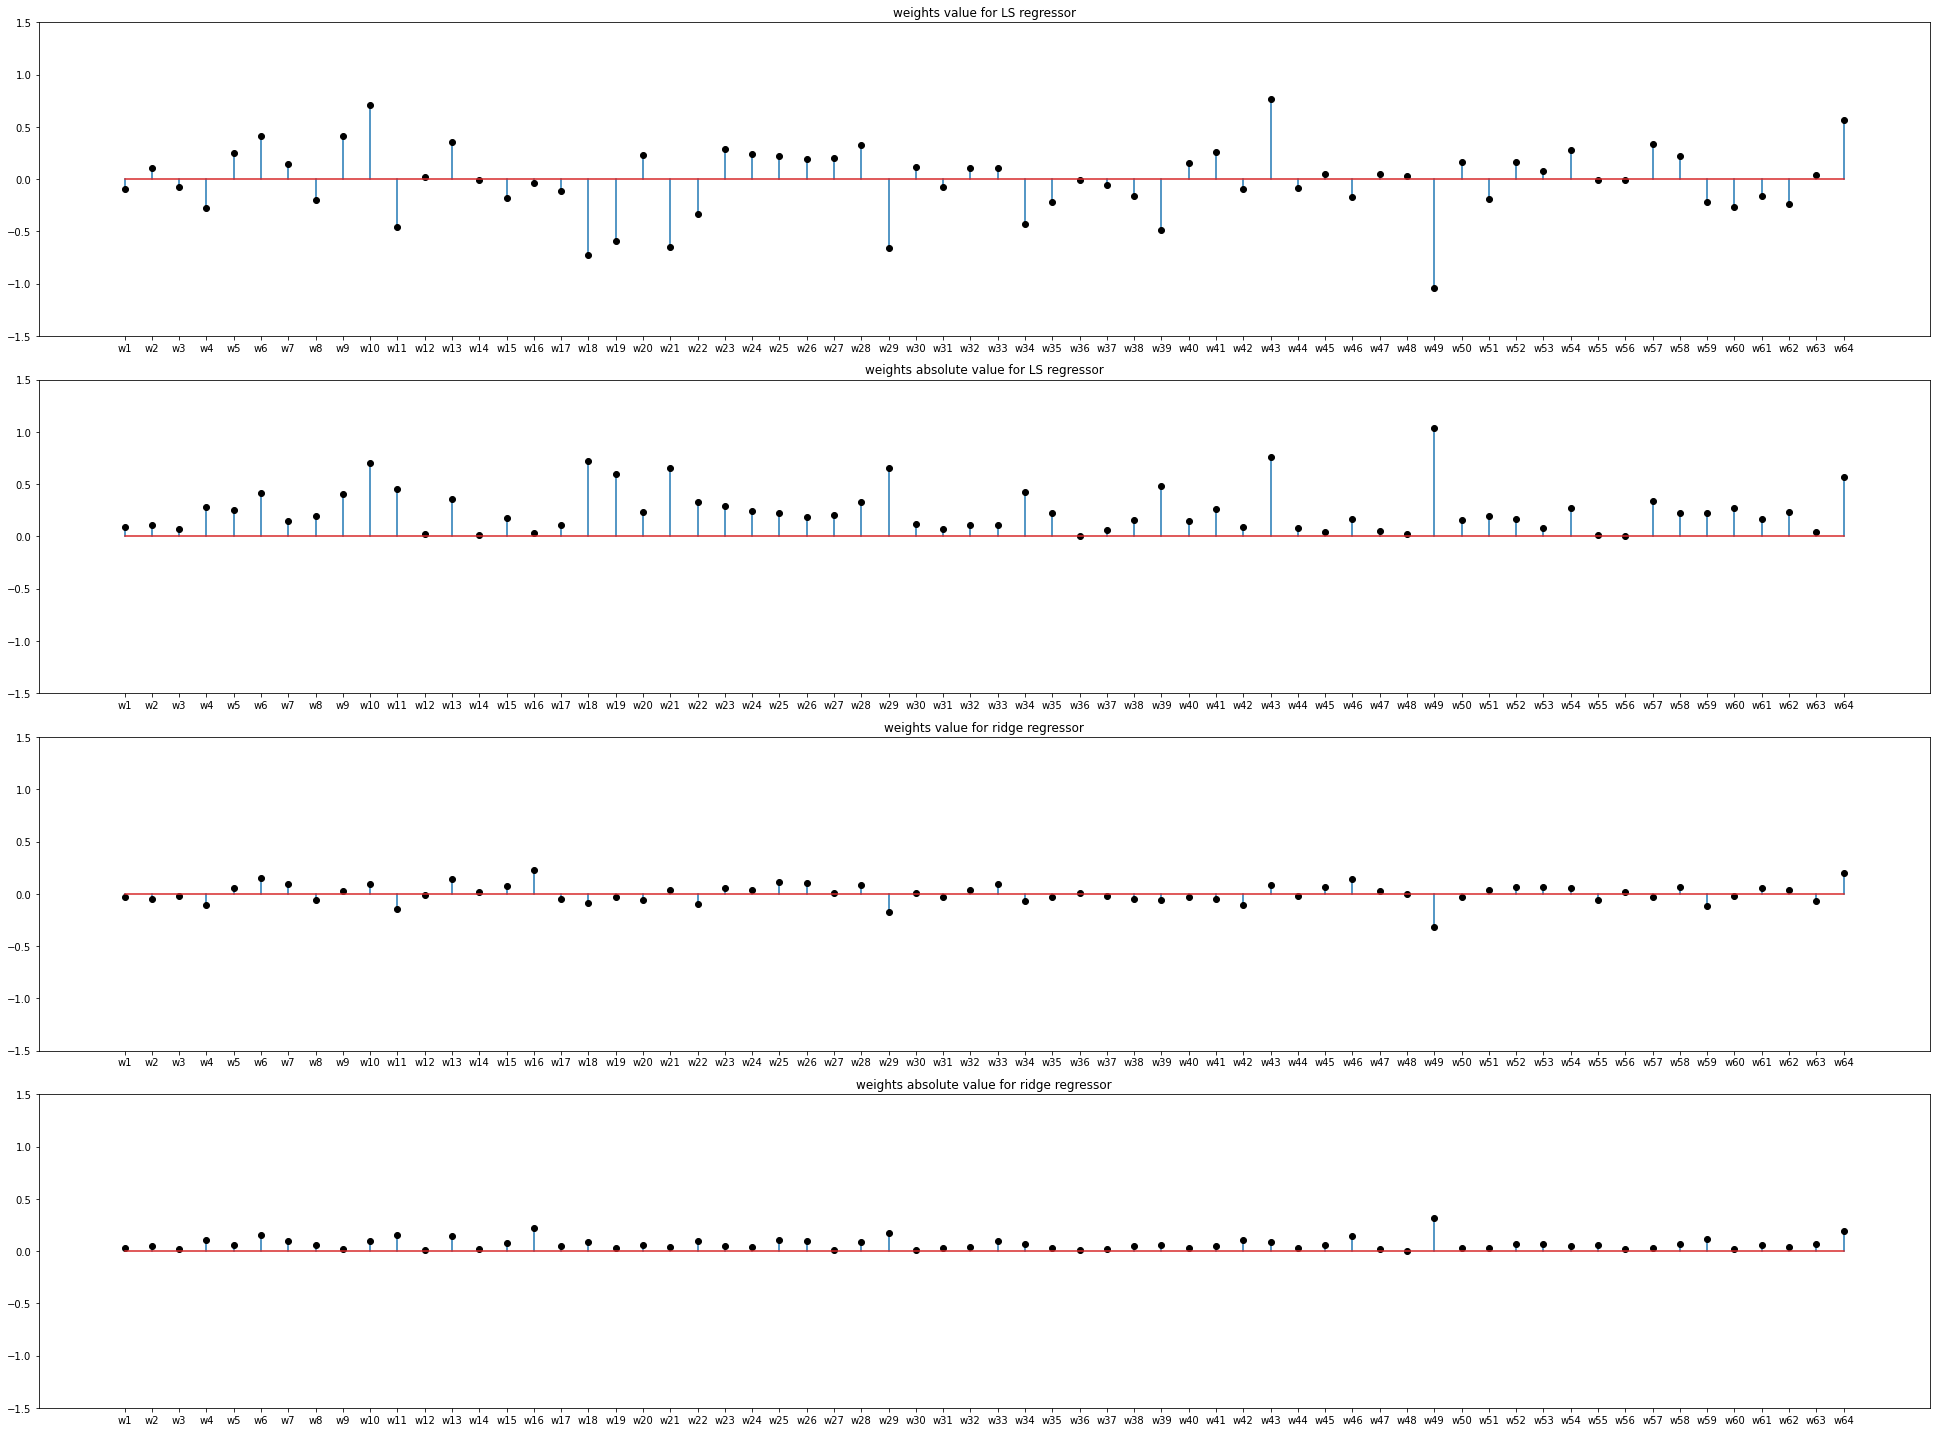

In [28]:
fig,axes=pl.subplots(4,1,figsize=(27,20))
x=[i for i in range(1,x_train.shape[1]+1)]
BarName=["w{}".format(i) for i in range(1,x_train.shape[1]+1)]

axes[0].stem(x, w[:,0] ,markerfmt='ko')
axes[0].set_xticks(x, minor=False)
axes[0].set_xticklabels(BarName)
axes[0].axis(ymin=-1.5,ymax=1.5)
axes[0].set_title("weights value for LS regressor")

axes[1].stem(x, abs(w[:,0]) ,markerfmt='ko')
axes[1].set_xticks(x, minor=False)
axes[1].set_xticklabels(BarName)
axes[1].axis(ymin=-1.5,ymax=1.5)
axes[1].set_title("weights absolute value for LS regressor")

axes[2].stem(x, W[index,:] ,markerfmt='ko')
axes[2].set_xticks(x, minor=False)
axes[2].set_xticklabels(BarName)
axes[2].axis(ymin=-1.5,ymax=1.5)
axes[2].set_title("weights value for ridge regressor")

axes[3].stem(x, abs(W[index,:]) ,markerfmt='ko')
axes[3].set_xticks(x, minor=False)
axes[3].set_xticklabels(BarName)
axes[3].axis(ymin=-1.5,ymax=1.5)
axes[3].set_title("weights absolute value for ridge regressor")

pl.tight_layout()
pl.show()

If we compare the plotted values of weights for both models (LS and ridge regressors), we can see that for the LS regressor many variables have important values of weights. However by doing a ridge regularization, many variables had their weights shrunk closely to zero (with no equality to zero for most cases this is particular to ridge). For other weights, they have been reduced and they are the most important in prediction like $w_{16},w_{29},w_{49}$ and $w_{64}$. 

# Variable selection with the Lasso

In [29]:
Lasso_reg = Lasso()
Lasso_reg.fit(x_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
y_train_hat=Lasso_reg.predict(x_train)
y_test_hat=Lasso_reg.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 3.1405971577280063
MSE on test: 2.190675841640482
R² on train: 0.0
R² on test: -0.02729265197579034


We see that the fitted model with lasso regularization with default value ($\lambda=1$), has a larger error on train dataset and lower error on test dataset if we compare it to the initial LS model. Although we didn't search for the optimal value of parameter, the lasso model with default parameter value of $1$ seems to reduce the problem of overfitting. For the correlation values, we had zero values on both train and test setsshowing that the fitted model doesn't capture any linear variation between the given data and their predictions.

In [31]:
lmbd=np.logspace(-3,5,num=100)                                                       #range value of lambda
W=np.zeros((100,64))
y_hat_train=np.zeros((100,n))
y_hat_test=np.zeros((100,m))
MSE_train=np.zeros(100)
MSE_test=np.zeros(100)
for i in range(len(lmbd)):
    clf=Lasso(alpha=lmbd[i])
    clf.fit(x_train,y_train)

    y_hat_test[i,:]=np.ravel(clf.predict(x_test))
    y_hat_train[i,:]=np.ravel(clf.predict(x_train))
    W[i,:]=np.ravel(clf.coef_)

    MSE_train[i]=mean_squared_error(y_hat_train[i,:],y_train)
    MSE_test[i]=mean_squared_error(y_hat_test[i,:],y_test)

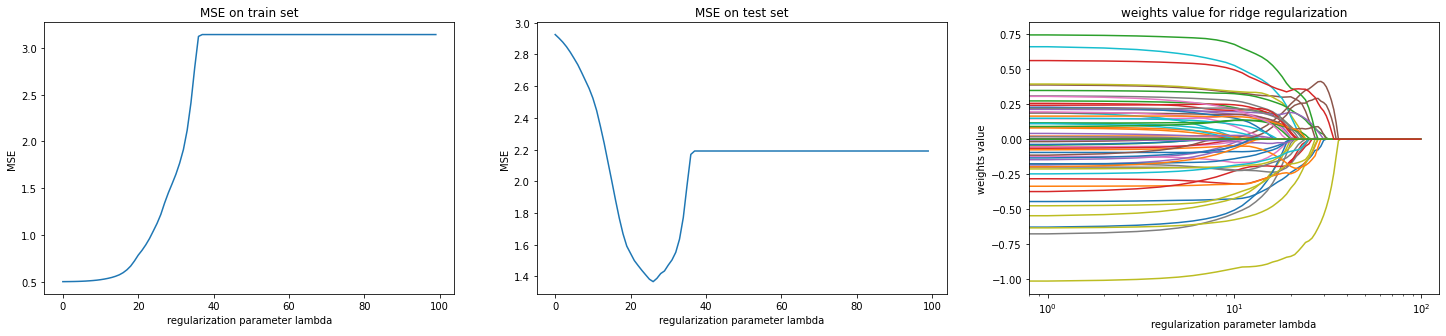

In [32]:
fig,axes=pl.subplots(1,3,figsize=(25,5))

axes[0].plot(MSE_train)
axes[0].set_xlabel("regularization parameter lambda")
axes[0].set_ylabel("MSE")
axes[0].set_title("MSE on train set")

axes[1].plot(MSE_test)
axes[1].set_xlabel("regularization parameter lambda")
axes[1].set_ylabel("MSE")
axes[1].set_title("MSE on test set")

axes[2].plot(W)
axes[2].set_xlabel("regularization parameter lambda")
axes[2].set_ylabel("weights value")
axes[2].set_xscale('log')
axes[2].set_title("weights value for ridge regularization")
pl.show()

In [33]:
index=np.argmin(MSE_test)
lmbd_opt=lmbd[index]
print("valeur optimale de lambda: {}".format(lmbd_opt)) 
print("MSE error on Test: {}".format(MSE_test[np.argmin(MSE_test)])) 
Lasso_opt=Lasso(alpha=lmbd_opt)
Lasso_opt.fit(x_train,y_train)

valeur optimale de lambda: 0.1261856883066021
MSE error on Test: 1.3659542352560023


Lasso(alpha=0.1261856883066021, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

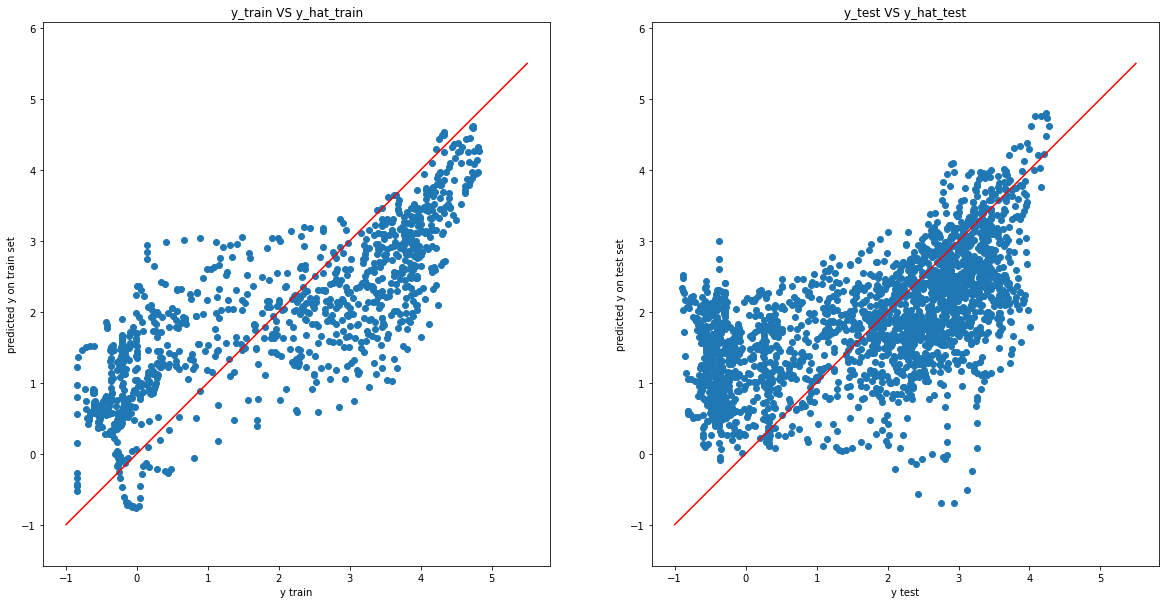

In [34]:
y_hat_test=Lasso_opt.predict(x_test)
y_hat_train=Lasso_opt.predict(x_train)

fig,axes=pl.subplots(1,2,figsize=(20,10))
line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[0])

axes[0].scatter(y_train,y_hat_train)
axes[0].add_line(line)
axes[0].set_xlabel("y train")
axes[0].set_ylabel("predicted y on train set")
axes[0].set_title("y_train VS y_hat_train")
axes[0].axis('equal')

line = mlines.Line2D([-1, 5.5], [-1, 5.5], color='red',axes=axes[1])

#axes[1].add_line(line)
axes[1].scatter(y_test,y_hat_test)
axes[1].add_line(line)
axes[1].set_xlabel("y test")
axes[1].set_ylabel("predicted y on test set")
axes[1].set_title("y_test VS y_hat_test")
axes[1].axis('equal')

pl.show()

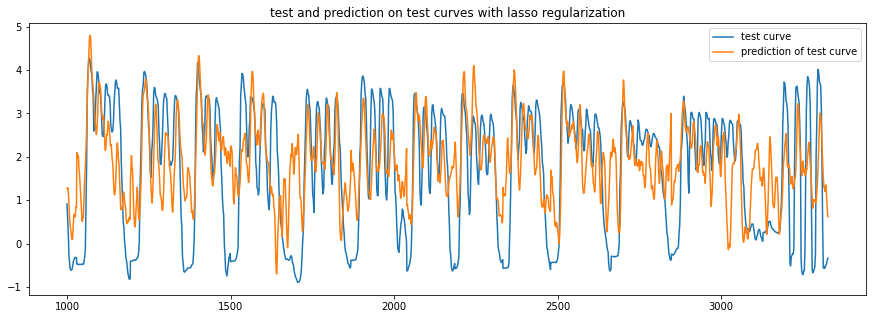

In [35]:
y_hat_test=Lasso_opt.predict(x_test)
y_hat_train=Lasso_opt.predict(x_train)

pl.figure(figsize=(15,5))
pl.plot(range(n,n+m),y_test,label="test curve")
pl.plot(range(n,n+m),y_hat_test,label="prediction of test curve")
pl.title("test and prediction on test curves with lasso regularization")
pl.legend()
pl.show()

With the lassor regularizer, we see that we had a very good approximation of the test curve. The predicted curve simulates well the test curve by reaching low values and following its variation. We see also that at the end the prediction is better than in the previous cases.

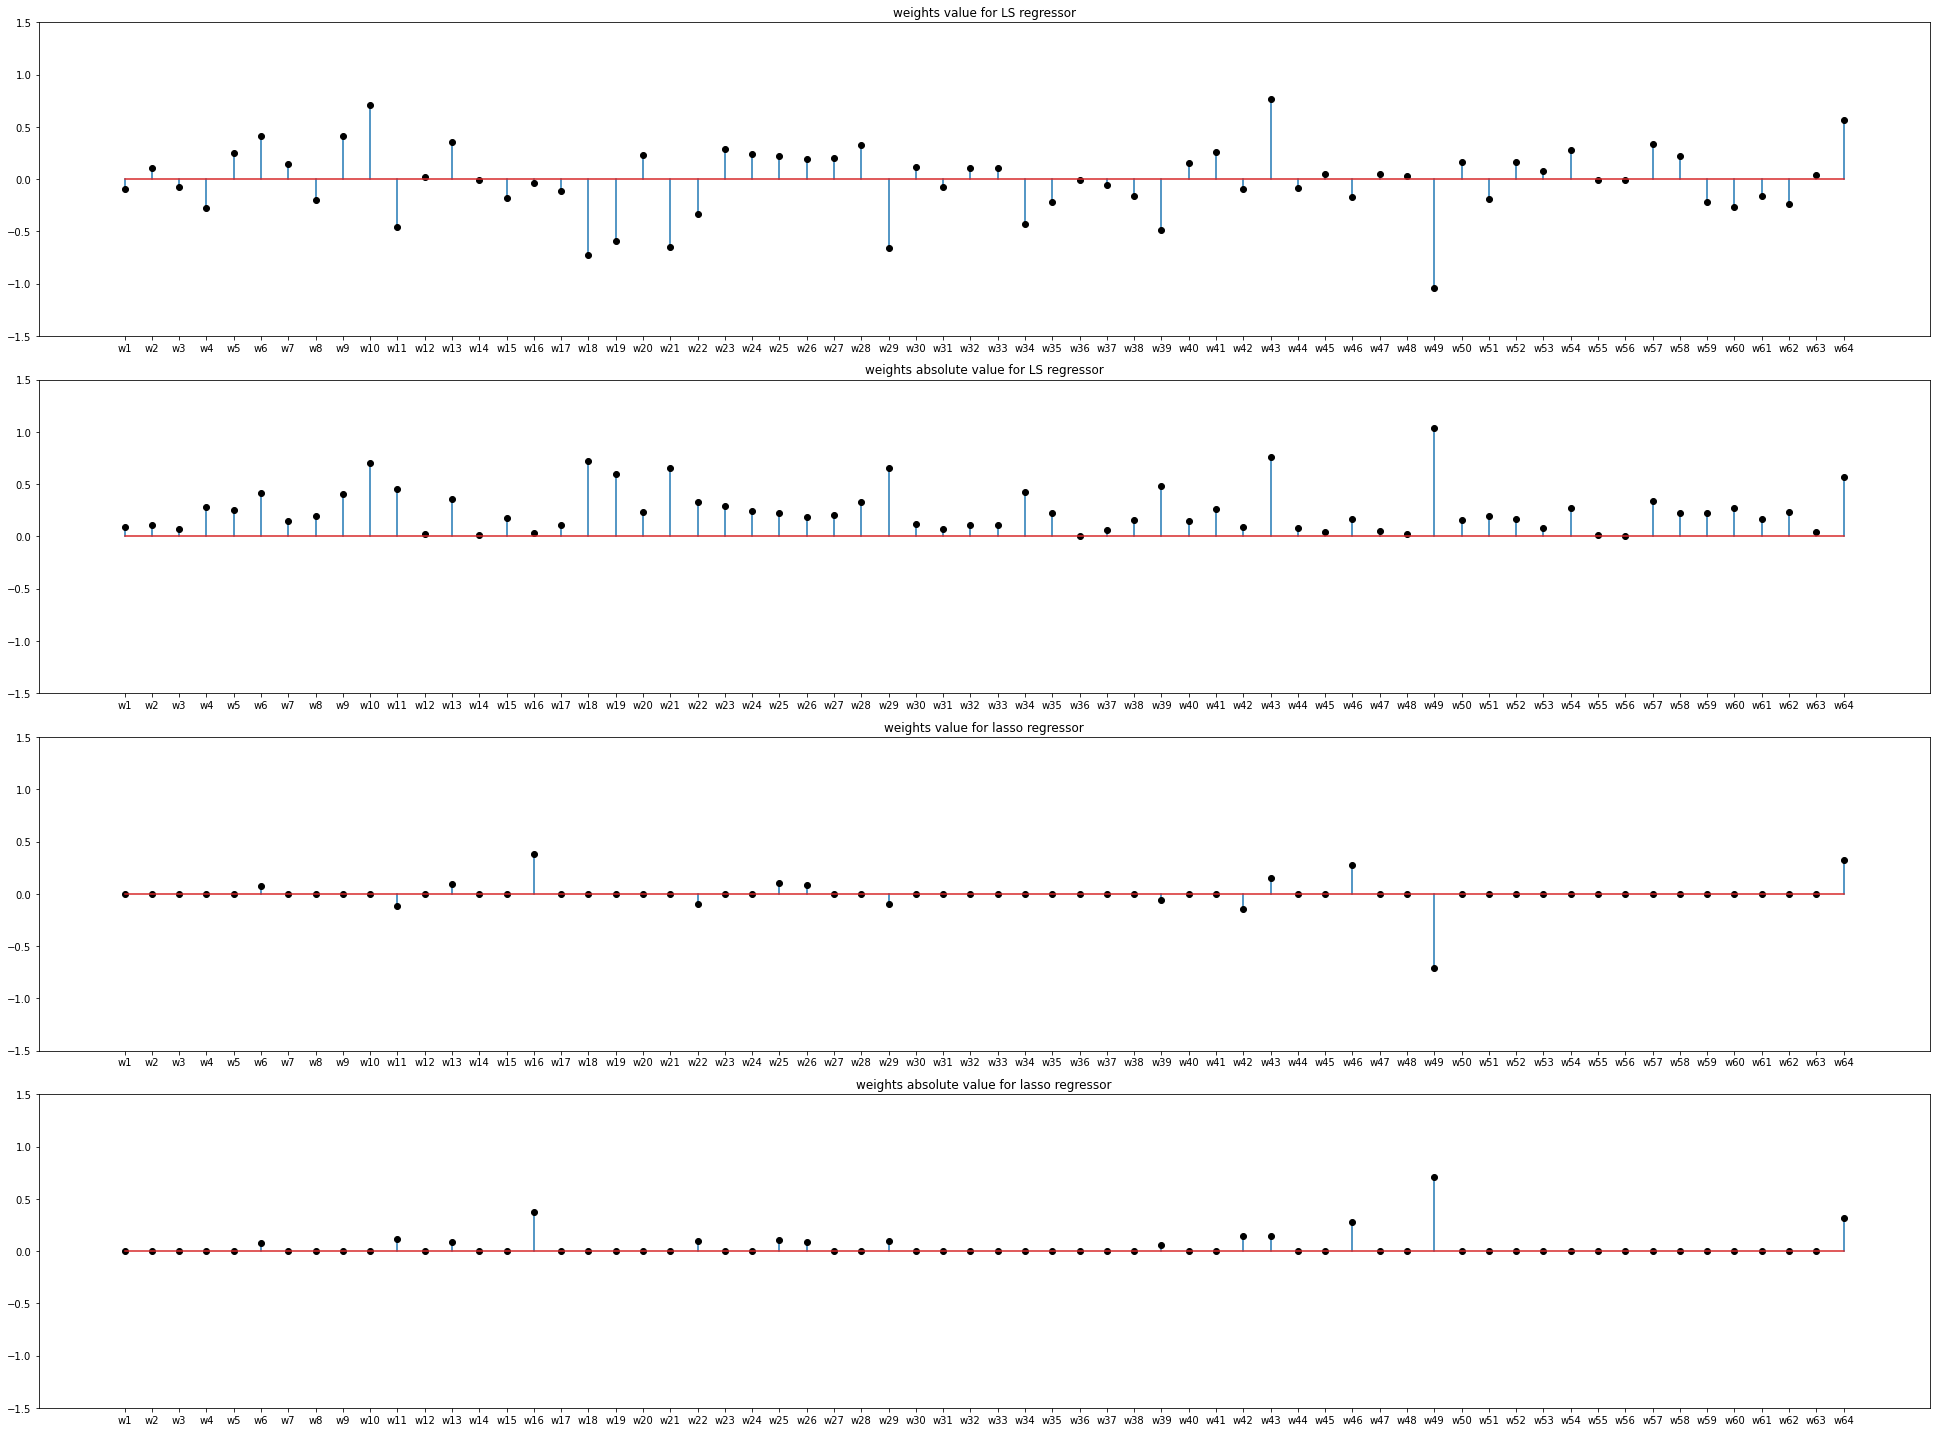

In [36]:
fig,axes=pl.subplots(4,1,figsize=(27,20))
x=[i for i in range(1,x_train.shape[1]+1)]
BarName=["w{}".format(i) for i in range(1,x_train.shape[1]+1)]

axes[0].stem(x, w[:,0] ,markerfmt='ko')
axes[0].set_xticks(x, minor=False)
axes[0].set_xticklabels(BarName)
axes[0].axis(ymin=-1.5,ymax=1.5)
axes[0].set_title("weights value for LS regressor")

axes[1].stem(x, abs(w[:,0]) ,markerfmt='ko')
axes[1].set_xticks(x, minor=False)
axes[1].set_xticklabels(BarName)
axes[1].axis(ymin=-1.5,ymax=1.5)
axes[1].set_title("weights absolute value for LS regressor")

axes[2].stem(x, W[index,:] ,markerfmt='ko')
axes[2].set_xticks(x, minor=False)
axes[2].set_xticklabels(BarName)
axes[2].axis(ymin=-1.5,ymax=1.5)
axes[2].set_title("weights value for lasso regressor")

axes[3].stem(x, abs(W[index,:]) ,markerfmt='ko')
axes[3].set_xticks(x, minor=False)
axes[3].set_xticklabels(BarName)
axes[3].axis(ymin=-1.5,ymax=1.5)
axes[3].set_title("weights absolute value for lasso regressor")

pl.tight_layout()
pl.show()

In [37]:
print("number of non null weights: {}".format(sum(W[index,:]!=0)))

number of non null weights: 14


We see that the lasso regularizer shuts down some variables by reducing their weights to zero. That's why we speak about variable selection with Lasso. By inspecting the weights of variables in the above plot, we see that variables with significantly non zero weights are $w_{16},w_{46},w_{49}$ and $w_{64}$. The other variables had their weights shrunk to zero or got very close to zero.

The number of features selected by the Lasso are the number of variables with non zero weights (Here we have $14$ variables havin non null coefficients). 

The reduced electrodes are not important in the prediction task. Indeed, we can interpret this by the fact that the actin of moving the finger implies one particular zone in the mind. And only the electrodes placed upon that zone are responsible for the prediction wheras the other ones are unecessary. For this task we see that a few number of electrods gives accurate results. So including a few number of electrods for measurement is way better than surrounding the mind of the subject with many electrods. 

# Nonlinear regression

## Random forest

In [38]:
rf=RandomForestRegressor(random_state=seed)
rf.fit(x_train,y_train)
y_train_hat=rf.predict(x_train)
y_test_hat=rf.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.023014741465302455
MSE on test: 1.6558946379239374
R² on train: 0.9926718581500749
R² on test: 0.2234869433208716


The default random forest model has a problem of over fitting to the train dataset. The results on the test dataset shows that the default random forest model is better than the LS model but it does not achieve better performance over the lasso and ridge. 

In [39]:
R=0
MSE=2
ngrid=30
param=0
param_grid={"max_features":np.linspace(0.5,0.7,num=ngrid)}                      
for i in range(ngrid):
    model=RandomForestRegressor(max_features=param_grid["max_features"][i],random_state=seed)                                   
    model.fit(x_train,y_train)
    y_hat=model.predict(x_test)
    mse=mean_squared_error(y_test,y_hat)
    r_2=metrics.r2_score(y_test,y_hat)
    if (abs(r_2)>R) and (mse<MSE):
        R=r_2
        MSE=mse
        param=param_grid["max_features"][i]

In [40]:
print("optimal value of max_features: {}".format(param))
rf_opt=RandomForestRegressor(max_features=param)
rf_opt.fit(x_train,y_train)

optimal value of max_features: 0.5689655172413793


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5689655172413793,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [41]:
y_train_hat=rf_opt.predict(x_train)
y_test_hat=rf_opt.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.021986337491900463
MSE on test: 1.5690960697599032
R² on train: 0.99299931306446
R² on test: 0.264190149875685


We coud reduce the MSE error by a value of $0.1$ and enhance the $R^2$ value by $0.05$ by tuning the max_features parameter, which shows that the model performance is dependent on the choice of its parameters.

We performed a grid search over the number of features considered in splitting data in the nodes of the decision trees. The best value was obtained for a precentage of $0.52$ of variables. 

We noted better performance on test data. The MSE error was reduced to $0.1$ from $1.64$ on test dataset for the model with default parameters as well as the $R^2$ value increased to $0.269$ on test dataset from $0.228$ for the model with default parameters. The MSE and $R^2$ on train data did not approximately change reflecting a problem of overfitting.

The random forest model is better than the LS model since it achieves higher $R^2$ value than the negative value obtained with the LS model as well as the MSE error is lower for random forest model $(1.55<3.045)$.

Compared to the Ridge regressor, the random forest model is performing better on test dataset: lower MSE error ($1.557<1.623$) and higher $R^2$ ($0.269>0.238$). This is explained by the fact that the random forest considered a fewer number of variables in the splits howerver the ridge model only reduces the weights of some variables.

Compared to the Lasso regressor, the latter one is better than the random forest model. In fact, for the MSE values we obtained $1.36$ on the test dataset for the Lasso model and $1.55$ for the random forest model on test dataset. For this case, the variable selection with Lasso is better than the random forest model.

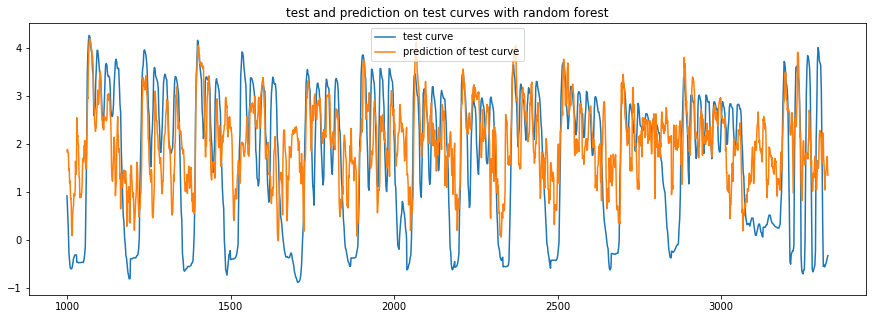

In [42]:
pl.figure(figsize=(15,5))
pl.plot(range(n,n+m),y_test,label="test curve")
pl.plot(range(n,n+m),y_test_hat,label="prediction of test curve")
pl.title("test and prediction on test curves with random forest")
pl.legend()
pl.show()

As we discussed above, the prediction on test dataset is not that bad. It's better than LS and ridge but less good than lasso. We see that the prediction captures in general the test curve. At the end we see a large difference between prediction and ground truth. In fact the random forest regressor assigns the average value of the split zones. And this prediction value is not always good for any test dataset as in our case.

## SVR

In [43]:
svr=SVR()
svr.fit(x_train,y_train)

y_train_hat=svr.predict(x_train)
y_test_hat=svr.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.024085982516610364
MSE on test: 1.515182870123942
R² on train: 0.9923307634481734
R² on test: 0.28947213490412815


The default SVR model has a problem of over fitting to the train dataset (very low value of MSE on train set and approximately a value of $1$ of $R^2$). The results on the test dataset shows that the default random forest model is better than the LS model as well as the ridge but it does not achieve better performance over the lasso.

In [44]:
R=0
MSE=2
ngrid=30
param={"epsilon":0,"C":0}
param_grid={"epsilon":np.logspace(-4,-1,ngrid),"C":np.linspace(0.1,10,ngrid)} 
for c in param_grid["C"]:
    for eps in param_grid["epsilon"]:
        model=SVR(epsilon=eps,C=c)                                   
        model.fit(x_train,y_train)
        y_hat=model.predict(x_test)
        mse=mean_squared_error(y_test,y_hat)
        r_2=metrics.r2_score(y_test,y_hat)
    if (abs(r_2)>R) and (mse<MSE):
        R=r_2
        MSE=mse
        param["epsilon"]=eps
        param["C"]=c

In [45]:
print("optimal value of C: {}".format(param["C"]))
print("optimal value of epsilon: {}".format(param["epsilon"]))

svr_opt=SVR(epsilon=param["epsilon"],C=param["C"])   
svr_opt.fit(x_train,y_train)


optimal value of C: 0.7827586206896552
optimal value of epsilon: 0.1


SVR(C=0.7827586206896552, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='scale', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

In [46]:
y_train_hat=svr_opt.predict(x_train)
y_test_hat=svr_opt.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.035081915722641376
MSE on test: 1.512864107005957
R² on train: 0.9888295397465046
R² on test: 0.29055949263524494


We see that with SVR model we did not change a lot the performance on test dataset by tuning the parameters of the model. The performance of the SVM model on our test dataset is not very dependent on the parameters of the model.

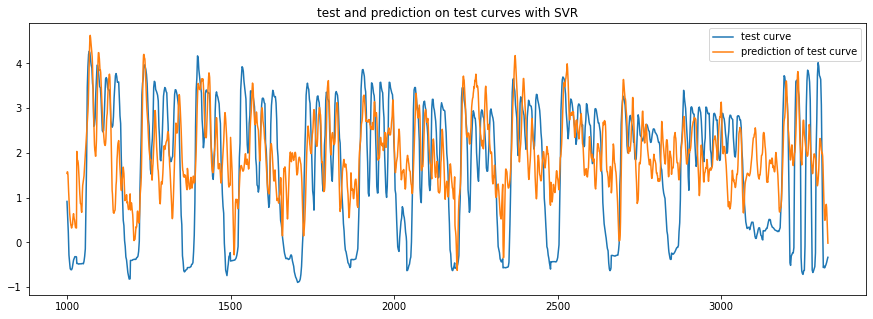

In [47]:
pl.figure(figsize=(15,5))
pl.plot(range(n,n+m),y_test,label="test curve")
pl.plot(range(n,n+m),y_test_hat,label="prediction of test curve")
pl.title("test and prediction on test curves with SVR")
pl.legend()
pl.show()

We see that the prediction on test dataset with SVR model is quite accurate. The predicted curve simulates the test curve. It reaches low value in some points. But in the end the prediction is not good.

## MLP

In [48]:
NN=MLPRegressor()
NN.fit(x_train,y_train)

y_train_hat=NN.predict(x_train)
y_test_hat=NN.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.008892168229576405
MSE on test: 2.1137735699845237
R² on train: 0.9971686377516786
R² on test: 0.008769798292183717


The default MLP model has a problem of over fitting to the train dataset (very low value of MSE on train set and approximately a value of $1$ of $R^2$). The results on the test dataset shows that the default random forest model is better than the LS model but it does not achieve better performance over the ridge and lasso.

In [49]:
R=0
MSE=3
ngrid=100
alpha_opt=0
alpha=np.linspace(100,300,num=ngrid) 
for e in alpha:
    model=MLPRegressor(max_iter=200,alpha=e)                                
    model.fit(x_train,y_train)
    y_hat=model.predict(x_test)
    mse=mean_squared_error(y_test,y_hat)
    r_2=metrics.r2_score(y_test,y_hat)
    if (abs(r_2)>R) and (mse<MSE):
        R=r_2
        MSE=mse
        alpha_opt=e

In [50]:
NN_opt=MLPRegressor(max_iter=200,alpha=alpha_opt)
NN_opt.fit(x_train,y_train)

y_train_hat=NN_opt.predict(x_train)
y_test_hat=NN_opt.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 1.0043938885986385
MSE on test: 1.6478442870285654
R² on train: 0.6801901555163972
R² on test: 0.22726206429652873


By tuning the parapeters of the MLP regressor we had better results on test dataset: the MSE error was rduced from $2.32$ to $1.619$ and the $R^2$ value increased from $0$ to $0.24$. We note also that the MSE on train has increased a lot and the $R^2$ value decreased. This means that we controlled the problem of overfitting to have better results on test.
By this we can say that MLP model performance is very dependent on parameters of the model.

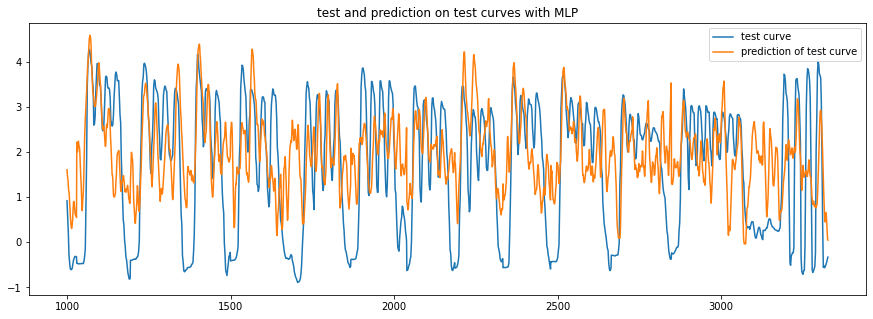

In [51]:
pl.figure(figsize=(15,5))
pl.plot(range(n,n+m),y_test,label="test curve")
pl.plot(range(n,n+m),y_test_hat,label="prediction of test curve")
pl.title("test and prediction on test curves with MLP")
pl.legend()
pl.show()

We see that the prediction on test dataset with SVR model is quite acceptable. The predicted curve simulates the test curve. However it has a default in not reaching low values. And predictions in the end are not good as well.

## Gradient Boosting Regressor

In [52]:
gbr=GBR(random_state=seed)
gbr.fit(x_train,y_train)

y_train_hat=gbr.predict(x_train)
y_test_hat=gbr.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.11333713838888565
MSE on test: 1.6781195743659556
R² on train: 0.9639122330254936
R² on test: 0.2130648108156732


The default GBR results on test dataset shows that its performance is better than LS. But lasso and ridge regressors are better than the default GBR model.

In [53]:
R=0
MSE=2
ngrid=30
param={"max_features":0,"subsample":0}
param_grid={"max_features":np.linspace(0.5,0.7,num=ngrid),"subsample":[0.4,0.5,0.6]}                      
for m in param_grid["max_features"]:
    for s in param_grid["subsample"]:
        model=GBR(max_features=m,subsample=s,random_state=seed)                                   
        model.fit(x_train,y_train)
        y_hat=model.predict(x_test)
        mse=mean_squared_error(y_test,y_hat)
        r_2=metrics.r2_score(y_test,y_hat)
        if (abs(r_2)>R) and (mse<MSE):
            R=r_2
            MSE=mse
            param["max_features"]=m
            param["subsample"]=s

In [54]:
print("optimal value of max_features: {}".format(param["max_features"]))
print("optimal value of subsample: {}".format(param["subsample"]))

GBR_opt=GBR(max_features=param["max_features"],subsample=param["subsample"],random_state=seed)
GBR_opt.fit(x_train,y_train)

optimal value of max_features: 0.6586206896551724
optimal value of subsample: 0.5


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=0.6586206896551724, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=123, subsample=0.5, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
y_train_hat=GBR_opt.predict(x_train)
y_test_hat=GBR_opt.predict(x_test)

print(f'MSE on train: {mean_squared_error(y_train,y_train_hat)}')
print(f'MSE on test: {mean_squared_error(y_test,y_test_hat)}')

print(f'R² on train: {metrics.r2_score(y_train,y_train_hat)}')
print(f'R² on test: {metrics.r2_score(y_test,y_test_hat)}')

MSE on train: 0.09540001198937981
MSE on test: 1.5132264549304484
R² on train: 0.9696236074866746
R² on test: 0.2903895736754366


We see that we reduced the MSE error on test dataset from $1.67$ to $1.51$. Also the $R^2$ value increased from $0.21$ to $0.29$ showing that GBM model performance are dependent on the choice of parameters we set.

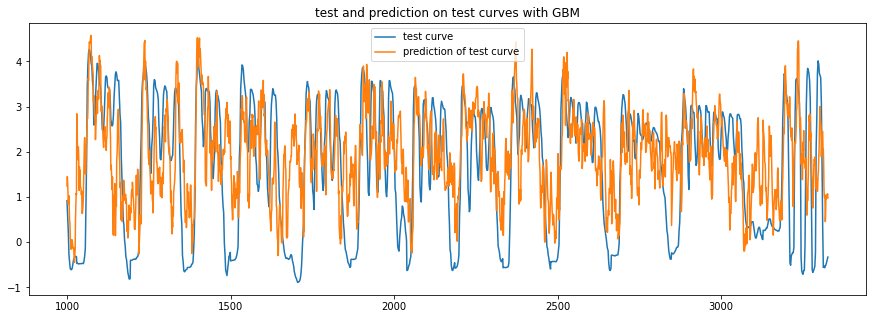

In [58]:
pl.figure(figsize=(15,5))
pl.plot(range(n,n+m),y_test,label="test curve")
pl.plot(range(n,n+m),y_test_hat,label="prediction of test curve")
pl.title("test and prediction on test curves with GBM")
pl.legend()
pl.show()

The gradient boosting regressor captures well the test curve. We see that compared to the other models it does not only capture the variations but also the low values of the curve. And even at the end, the prediction simulates quitely the test curve.

#  Final comparison of the performances

In [59]:
models=[LS,Ridge_opt,Lasso_opt,rf_opt,svr_opt,NN_opt,GBR_opt]
data={"model":["LS","Ridge","Lasso","Random forest","SVR","MLP","Gradient boosting"],
      "MSE on test": [mean_squared_error(y_test,model.predict(x_test)) for model in models],
      "R²":[metrics.r2_score(y_test,model.predict(x_test)) for model in models]}
df = pd.DataFrame(data,columns=['model','MSE on test','R²'])
df

,model,MSE on test,R²
0,LS,3.045537,-0.428170
1,Ridge,1.623906,0.238488
2,Lasso,1.365954,0.359451
3,Random forest,1.569096,0.264190
4,SVR,1.512864,0.290559
5,MLP,1.647844,0.227262
6,Gradient boosting,1.513226,0.290390


We order the models by their performances on the test data starting from the best one:


1-Lasso


2-SVR


3-Gradient boosting


4-Random forest


5-MLP


6-Ridge


7-LS

The most interpretable models are the linear models (LS,Lasso and Ridge). The bagging models are less interptretable such as random forest and Gradient boosting. And non linear models like MLP are less interptretable.

From a medical/practical perspective, the best model here is linear regression with lasso regularizer. Since we work in high dimensionality, using Lasso regularizer leaves only the most pertinent and correlated variables. Since the variables represent the electrodes used in the measurement, using a fewer number of electrodes is more adequate and than too many of electrodes to be placed upon a subject's mind. And we can see that with the Lasso regularizer we obtained the best results which makes it the best model for this task.

In this application we don't need non-linearity since we could achieve good results with the linear regressor with lasso regularizer. Using non-linear models is not always a good choice when we have satisfying results with linear models.

Validation on test data is not a good practice. In fact, the test data should not be used to choose the model. What we should do is to take a subse from train dataset and use it as a validation data. Or perform cross validation over train dataset.